---

### **$Project$**

---



*This project successfully designed, implemented, and validated a complete two-stage pipeline for instruction-based object removal. The goal was to take a source image and a text prompt, accurately identify the specified object, and then realistically inpaint the area to seamlessly remove it. This was achieved by developing two distinct models: a custom segmentation model for detection and a fine-tuned diffusion model for inpainting.*





#### **$Segmentation$ $Phase$**




In the first phase, we developed a custom `ConditionedUNet` architecture to perform text-guided segmentation. After a rigorous evaluation against a powerful pre-trained `CLIPSeg` baseline, our model demonstrated **superior performance**, particularly in its ability to reliably localize objects. The "Box vs. Box" metrics on the validation set confirmed that our U-Net was more accurate and consistent than the baseline. Based on this evidence, we selected our **`ConditionedUNet`** and its **bounding box mask** predictions as the definitive method for the detection stage.





#### **$Inpainting$ $Phase$**




In the second phase, we fine-tuned a `StableDiffusion-2-Inpainting` model using Low-Rank Adaptation (LoRA) on our specific task of filling the bounding box regions. The qualitative, side-by-side comparison against the original pre-trained Stable Diffusion model showed a **good improvement**. Our fine-tuned model exhibited a greater understanding of scene context, reconstructing complex backgrounds like water and seamlessly integrating the inpainted region, whereas the baseline often produced unrealistic or contextually incorrect results.




#### **$Final$ $Verdict$**




Ultimately, this project has been a definitive success. We have created a complete, end-to-end system that effectively translates a natural language instruction into a high-quality, edited image. By combining a custom-trained segmentation network with a fine-tuned generative inpainting model, we have produced a pipeline that is not only functional but has also been proven superior to established baselines at each critical stage.

---

#### $Load$ $Libraries$

---

In [12]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionInpaintPipeline, DDIMScheduler
from torchvision import transforms, models
import pickle
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPTextModel, CLIPTokenizer
import os

---

#### $Object$ $Detection$ $-$ $Unet$

---

In [3]:
class TransformerCrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, text_dim=512):
        super().__init__()
        self.text_proj = nn.Linear(text_dim, embed_dim)
        self.ln = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x, text_tokens):
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1).permute(0, 2, 1)  # [B, N, C]

        text_tokens = self.text_proj(text_tokens)  # [B, 77, embed_dim]
        text_tokens = self.ln(text_tokens)

        out, _ = self.attn(query=x_flat, key=text_tokens, value=text_tokens)
        out = out.permute(0, 2, 1).view(B, C, H, W) # Becomes [Batch, Num_Pixels, Channels]
        return x + out


class ResNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch, downsample=False):
        super().__init__()
        stride = 2 if downsample else 1
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        
        if in_ch != out_ch or downsample:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity
        out = self.relu(out)
        return out


class UpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, embed_dim, num_heads, text_dim=512):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        # First ResNet block handles the channel reduction and combines features
        self.res_block1 = ResNetBlock(in_ch + skip_ch, out_ch)
        
        # Second ResNet block for additional processing
        self.res_block2 = ResNetBlock(out_ch, out_ch)
        
        self.cross_attn = TransformerCrossAttention(out_ch, num_heads, text_dim=text_dim)

    def forward(self, x, skip, tokens):
        x = self.upsample(x)
        x = F.pad(x, [0, skip.shape[3] - x.shape[3], 0, skip.shape[2] - x.shape[2]])
        x = torch.cat([x, skip], dim=1)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        
        return self.cross_attn(x, tokens)


class ConditionedUNet(nn.Module):
    def __init__(self, text_model_name='openai/clip-vit-base-patch32', num_heads=4):
        super().__init__()
        self.text_encoder = CLIPTextModel.from_pretrained(text_model_name)
        self.text_dim = self.text_encoder.config.hidden_size

        resnet = models.resnet18(pretrained=True)
        self.encoder0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4
        
        self.cross2 = TransformerCrossAttention(128, num_heads, text_dim=self.text_dim)  # For encoder2
        self.cross3 = TransformerCrossAttention(256, num_heads, text_dim=self.text_dim)
        self.cross4 = TransformerCrossAttention(512, num_heads, text_dim=self.text_dim)
        self.up1 = UpBlock(512, 256, 256, embed_dim=256, num_heads=num_heads, text_dim=self.text_dim)
        self.up2 = UpBlock(256, 128, 128, embed_dim=128, num_heads=num_heads, text_dim=self.text_dim)
        self.up3 = UpBlock(128, 64, 64, embed_dim=64, num_heads=num_heads, text_dim=self.text_dim)
        self.up4 = UpBlock(64, 64, 32, embed_dim=32, num_heads=num_heads, text_dim=self.text_dim)

        self.out_conv = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1)
        )

    def forward(self, img, input_ids, attention_mask):
        B, _, H, W = img.shape
        text_out = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        tokens = text_out.last_hidden_state  # [B, 77, text_dim]

        x0 = self.encoder0(img)
        x1 = self.encoder1(x0)
        
		
        x2 = self.cross2(self.encoder2(x1), tokens) 
        x3 = self.cross3(self.encoder3(x2), tokens)
        x4 = self.cross4(self.encoder4(x3), tokens)

        d1 = self.up1(x4, x3, tokens)
        d2 = self.up2(d1, x2, tokens)
        d3 = self.up3(d2, x1, tokens)
        d4 = self.up4(d3, x0, tokens)

        return F.interpolate(self.out_conv(d4), size=(H, W), mode="bilinear", align_corners=False)

In [ ]:
# Configuration 
device = "cuda" if torch.cuda.is_available() else "cpu"
unet_weights_path = "best_model.pt" # Path to the trained segmentation model

In [9]:
# Load the Segmentation U-Net
print("Loading Segmentation U-Net...")
segmentation_model = ConditionedUNet().to(device)
segmentation_model.load_state_dict(torch.load(unet_weights_path, map_location=device))
segmentation_model.eval()
print("✓ Segmentation model loaded.")


Loading Segmentation U-Net...


/home/lefki/msc/deep_learning/.venv311/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lefki/msc/deep_learning/.venv311/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Segmentation model loaded.


---

#### $Image$ $Inpainting$ $-$ $Stable$ $Diffusion$ $with$ $LoRA$

---

In [ ]:
# Define all the paths 
base_dir = "/dataset"
output_dir_main = os.path.join(base_dir, "diffusion") # The new folder you requested
lora_checkpoint_dir = "./lora-inpaint-out"
splits_to_process = ["val", "test"]

# Find the latest LoRA checkpoint
all_checkpoints = [d for d in os.listdir(lora_checkpoint_dir) if d.startswith("checkpoint-")]
latest_checkpoint = sorted(all_checkpoints, key=lambda x: int(x.split('-')[1]))[-1]
lora_model_path = os.path.join(lora_checkpoint_dir, latest_checkpoint)

print(f"Loading fine-tuned LoRA weights from: {lora_model_path}")

# Load the base pipeline and apply your LoRA weights
base_model_id = "stabilityai/stable-diffusion-2-inpainting"
inpaint_pipe = StableDiffusionInpaintPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
inpaint_pipe.load_lora_weights(lora_model_path)
inpaint_pipe.to("cuda")
print("Pipeline loaded and moved to GPU.")


Loading fine-tuned LoRA weights from: ./lora-inpaint-out/checkpoint-22500


Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 12.12it/s]
No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Pipeline loaded and moved to GPU.


In [ ]:
# Load necessary processors
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

---

#### $Full$ $Project$ $Pipeline$

---

In [ ]:
def run_and_visualize_pipeline(original_image, prompt_text):
    """
    Takes a PIL image and a text prompt, runs the full pipeline,
    and displays the final visualization.
    """
    print("Step 1: Running Segmentation Model...")
    # Prepare inputs for segmentation model
    img_tensor = img_transform(original_image).unsqueeze(0).to(device)
    tokens = tokenizer(prompt_text, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
    input_ids = tokens.input_ids.to(device)
    attention_mask = tokens.attention_mask.to(device)

    # Run Segmentation Model to get the mask
    with torch.no_grad():
        predicted_logits = segmentation_model(img_tensor, input_ids, attention_mask)
        predicted_prob = torch.sigmoid(predicted_logits)[0, 0].cpu()

    # Convert raw prediction to a bounding box mask
    mask_np = (predicted_prob > 0.4).numpy().astype(np.uint8) * 255
    ys, xs = np.where(mask_np > 0)
    if len(xs) > 0 and len(ys) > 0:
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
        box_mask_np = np.zeros_like(mask_np, dtype=np.uint8)
        box_mask_np[y1:y2+1, x1:x2+1] = 255
        generated_mask = Image.fromarray(box_mask_np).convert("L")
    else:
        print("Warning: Segmentation model did not detect anything.")
        generated_mask = Image.new("L", (512, 512), 0)

    print("Step 2: Running Inpainting Model...")
    # Prepare inputs for inpainting model
    source_image_512 = original_image.resize((512, 512))
    
    # Run Inpainting Model
    generator = torch.Generator(device="cuda").manual_seed(0)
    with torch.no_grad():
        inpainted_image = inpaint_pipe(
            prompt="",
            image=source_image_512,
            mask_image=generated_mask,
            generator=generator
        ).images[0]
        
    print("✓ Pipeline complete! Displaying result...")

    # Visualize the final result
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    fig.suptitle(f'End-to-End Result', fontsize=20, fontweight='bold')

    # Original Image
    axs[0].imshow(original_image.resize((512, 512))) # Show resized for consistent display
    axs[0].set_title("1. Original Image")
    axs[0].axis('off')

    # Prompt
    axs[1].text(0.5, 0.5, f"Prompt:\n'{prompt_text}'", fontsize=14, ha='center', va='center', wrap=True)
    axs[1].set_title("2. User Prompt")
    axs[1].axis('off')

    # Generated Mask
    axs[2].imshow(generated_mask, cmap='gray')
    axs[2].set_title("3. Generated Mask")
    axs[2].axis('off')

    # Final Output
    axs[3].imshow(inpainted_image)
    axs[3].set_title("4. Final Output")
    axs[3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


---

#### $Pipeline$ $Demonstration$

---

To demonstrate the pipeline's ability to perform nuanced, instruction-based segmentation, we conducted a comparative test on a single source image. The image was processed twice using two semantically distinct prompts to assess the model's contextual awareness:

1. `car at the center left` (singular)

2. `cars at the center` (plural)

This experiment was designed to verify that our system can accurately interpret subtle differences in language to generate precise, corresponding segmentation masks, moving beyond simple keyword detection

Step 1: Running Segmentation Model...
Step 2: Running Inpainting Model...


100%|██████████| 50/50 [00:02<00:00, 23.03it/s]


✓ Pipeline complete! Displaying result...


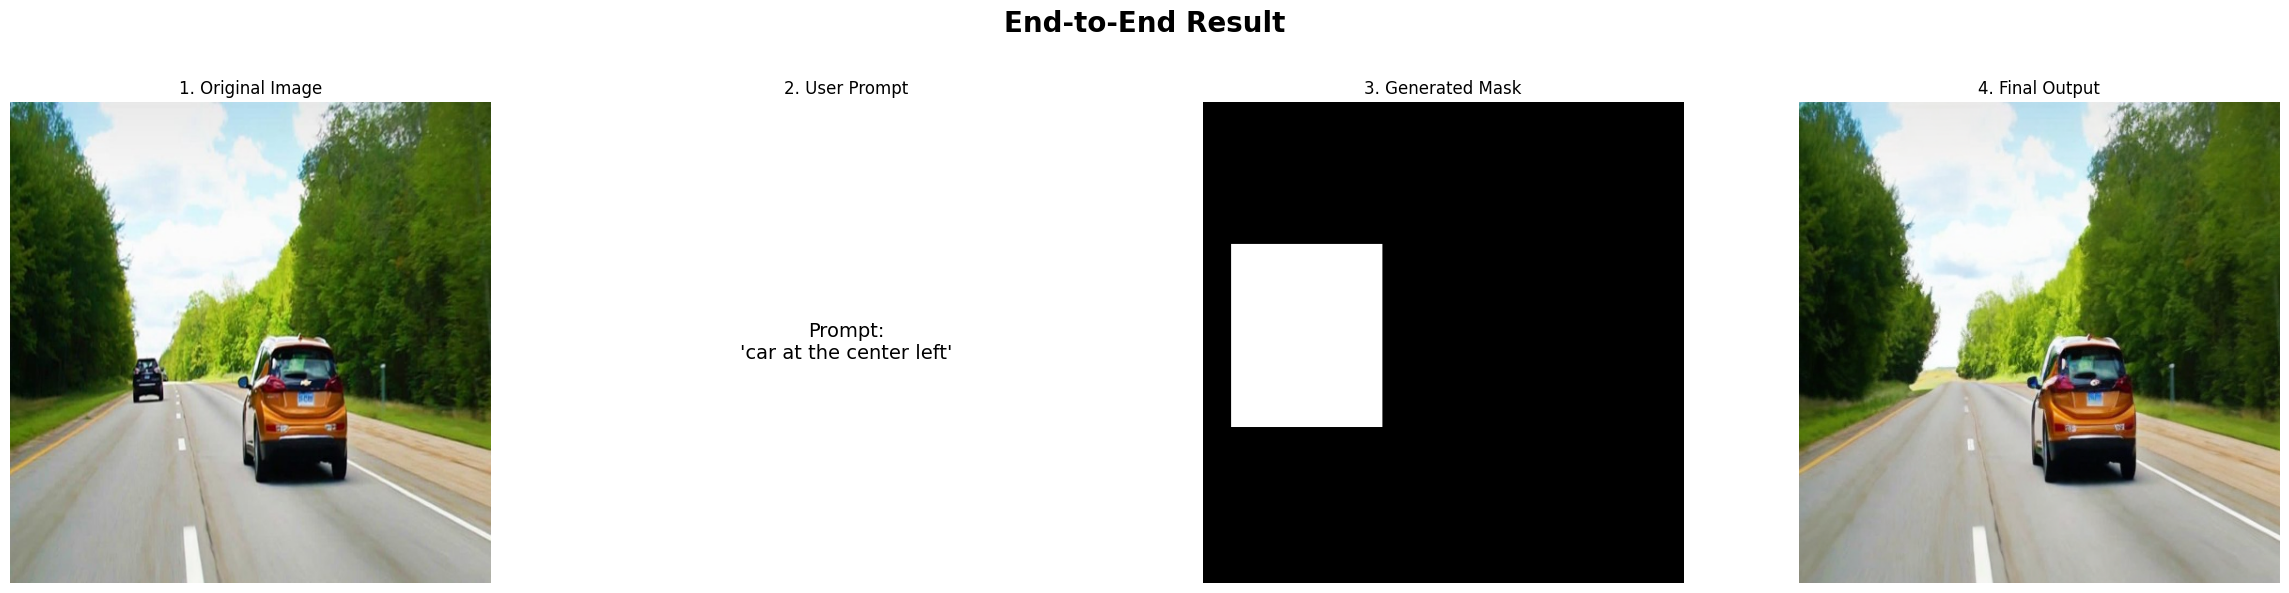

In [ ]:
# USER INPUT AND EXECUTION 

image_path = "photos/cars.jpg"
prompt = "car at the center left"

# Load the image
original_image = Image.open(image_path).convert("RGB")

# Run the entire pipeline and show the plot
run_and_visualize_pipeline(original_image, prompt)

Step 1: Running Segmentation Model...
Step 2: Running Inpainting Model...


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 22.79it/s]


✓ Pipeline complete! Displaying result...


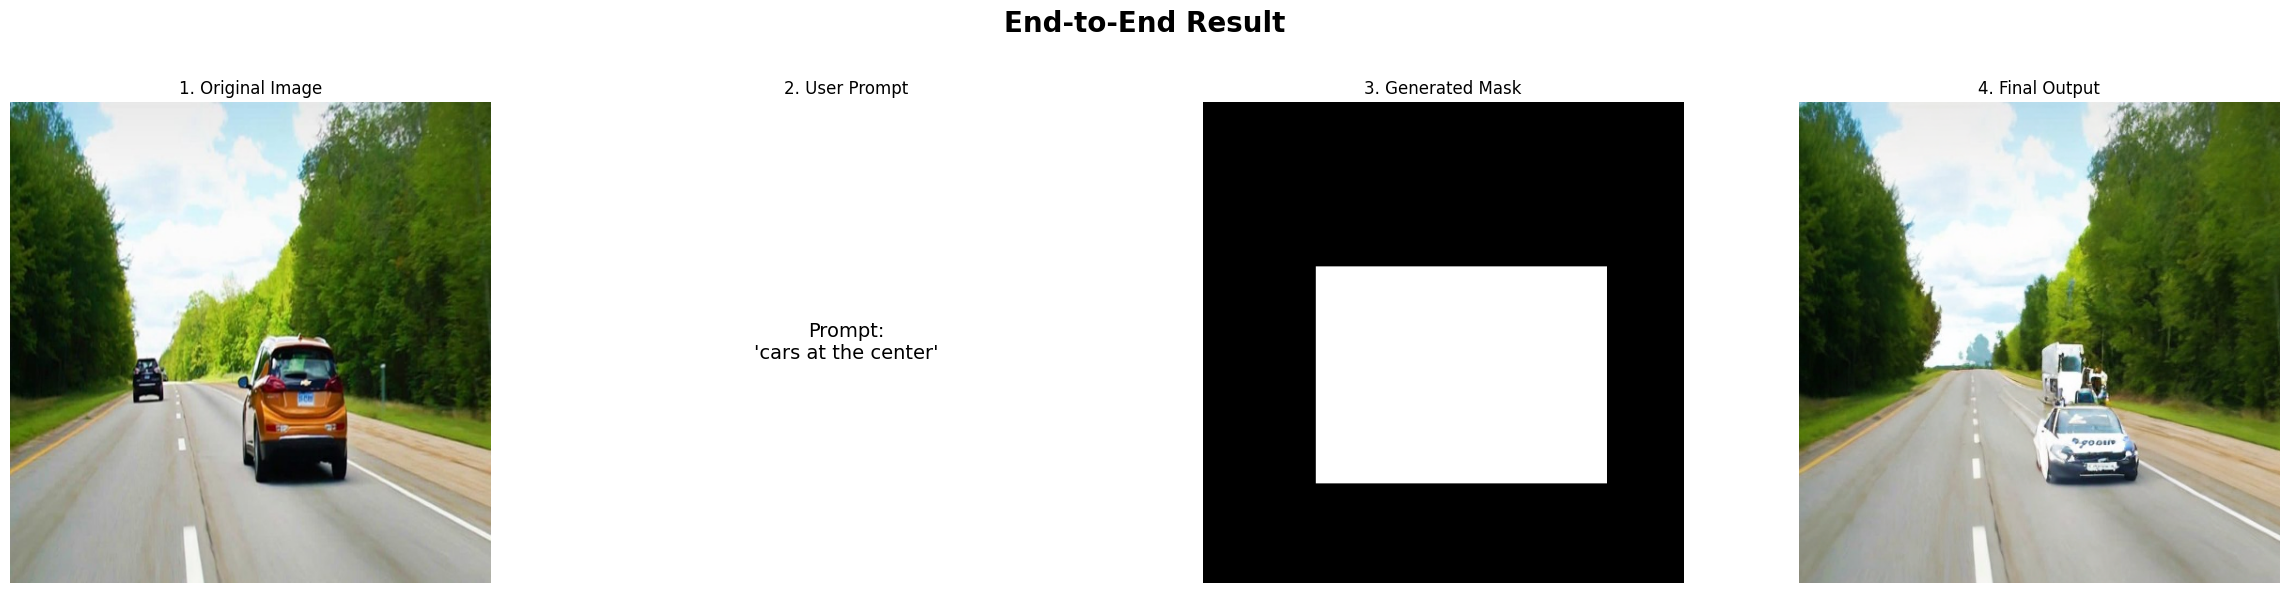

In [ ]:
image_path = "photos/cars.jpg"
prompt = "cars at the center"

# Load the image
original_image = Image.open(image_path).convert("RGB")

# Run the entire pipeline and show the plot
run_and_visualize_pipeline(original_image, prompt)